In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [2]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples))/64.0)
    
    sample=samples-s
    return sample, s

In [3]:
eeg=h5py.File('D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\a2018.10.06_11.20.50.hdf5',mode='r')
keys2= list(eeg.keys())
print keys2
keys1= list(eeg[keys2[0]].keys())
print keys1
#print eeg[keys2[0]][keys1[0]]
#eeg["RawData"]['Samples']
print list(eeg['RawData'].keys())
print eeg['RawData']['Samples'].shape[0]
sampletime = np.array(eeg['AsynchronData']["Time"])
time=sampletime/256.0
sampletime1=np.delete(sampletime, len(sampletime)-1)
#sampletime1=np.delete(sampletime1, len(sampletime1)-1)
#sampletime1=sampletime
sampletime1=np.delete(sampletime1, 0)
#sampletime1=np.delete(sampletime1, 0)
print sampletime
print sampletime1

[u'AsynchronData', u'RawData', u'SavedFeatues', u'Version']
[u'AsynchronSignalTypes', u'Time', u'TypeID', u'Value']
[u'AcquisitionTaskDescription', u'DAQDeviceCapabilities', u'DAQDeviceDescription', u'Samples', u'SessionDescription', u'SubjectDescription']
41940
[[11311]
 [41141]]
[]


In [33]:
samples=np.array(eeg['RawData']['Samples'])
samples=samples.T
samples, _= CAR(samples)
for i in range(0, len(samples)):
    z=baseline_als(samples[i], 10**4, 0.1, 10)
    samples[i]=samples[i]-z
    

In [5]:
def elliptic_bandpass(order, rp, rs, lowcut, highcut):
    fs=256
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.ellip(order, rp, rs, [low, high], btype='bandpass', analog=False, output='ba')
    return b, a

In [6]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [7]:
from scipy.fftpack import fft, ifft

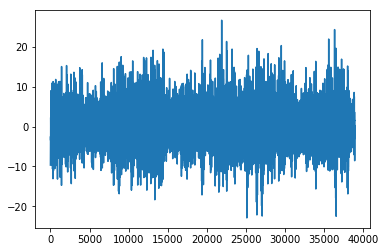

In [54]:
bsir=[]
fs=256
order=4
rp=0.5
rs=30
for i in range (0, len(samples)):
    b, a= elliptic_bandpass(order, rp, rs, 1, 25)
    bsir.append(signal.filtfilt(b, a, samples[i], padlen=0))
    
plt.plot(np.arange(len(bsir[13][3000:])), bsir[13][3000:])

In [9]:
bsi_channels=[[13, 31], [9, 27], [31, 49], [27, 45], [49, 59], [45, 57], [13, 33], [9, 25]]
bsi_channel_names=[['F4', 'C4'], ['F3', 'C3'], ['C4', 'P4'], ['C3', 'P3'], ['P4', 'O2'], ['P3', 'O1'], ['F4', 'T4'], 
                   ['F3', 'T3']]

In [62]:
def compute_bsi_t(bsir, t, T):
    ni=np.zeros(T)
    for i in range(0, len(bsi_channels)):
        
        rj=fft(bsir[bsi_channels[i][0]][t-T:t])
        lj=fft(bsir[bsi_channels[i][1]][t-T:t])
        ni=ni+sum(np.abs((lj-rj)/(lj+rj)))/len(rj)
    ni=sum(ni)/len(bsi_channels)
    print (ni.real)
    return ni

In [63]:
T=256*4   #window time
bsi=[]
for i in range(sampletime[0]+1024, sampletime[1], 1024):
    bsi.append(compute_bsi_t(bsir, i, T))
    #print i


3261.7655422668886
559.1456264929787
785.6561691756359
5684.92214197285
1505.910487000599
819.0644602592715
1764.2156848427967
1225.6215506902859
811.3362015981606
1872.5628386968597
1931.9486605643792
1497.592227916075
1478.5040901781363
2412.9779678769805
1548.4534075766976
1146.2650577621484
1885.6120580416678
641.0437510401129
901.0763895900125
2393.267911788038
1041.6623656134832
2255.148862800613
898.1063564053353
1638.3448890939471
5565.86271613589
2722.0492677782163
2335.919013245194
648.9645981971435
739.0986575956521


[3261.7655422668886, 559.1456264929787, 785.6561691756359, 5684.92214197285, 1505.910487000599, 819.0644602592715, 1764.2156848427967, 1225.6215506902859, 811.3362015981606, 1872.5628386968597, 1931.9486605643792, 1497.592227916075, 1478.5040901781363, 2412.9779678769805, 1548.4534075766976, 1146.2650577621484, 1885.6120580416678, 641.0437510401129, 901.0763895900125, 2393.267911788038, 1041.6623656134832, 2255.148862800613, 898.1063564053353, 1638.3448890939471, 5565.86271613589, 2722.0492677782163, 2335.919013245194, 648.9645981971435, 739.0986575956521]


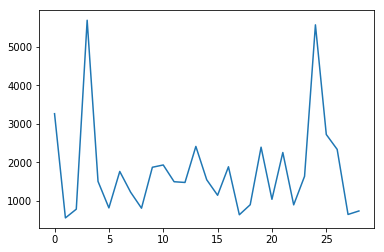

In [64]:
plt.plot(np.arange(len(bsi)), np.array(bsi))
print bsi

In [48]:
t=16431
ni=np.zeros(T)

rj=bsir[bsi_channels[1][0]][t-T:t]
print rj
#z1=baseline_als(bsir[bsi_channels[1][1]][t-T:t],10**4, 0.01, 10)
lj=bsir[bsi_channels[1][1]][t-T:t]
ni=ni+((fft(rj)-fft(lj))/(fft(rj)+fft(lj)))
print max(ni.real)

[3.33866165 2.74626548 2.15499741 ... 5.44296241 4.48353739 3.3343004 ]
3.7061633091467594


In [49]:
print len(bsi_channels)

8


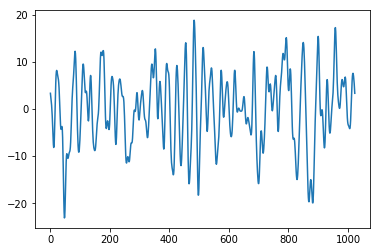

In [50]:
plt.plot(np.arange(len(rj)), rj)